In [1]:
# Import required modules
import cv2 as cv
import math
import time
import matplotlib.pyplot as plt

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20

def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace


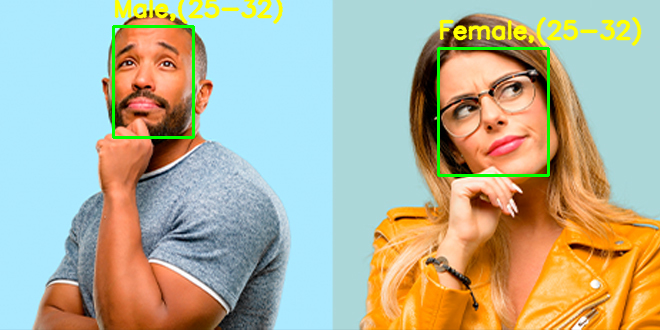

In [3]:
from PIL import Image

input = cv.imread("AgeandGender.jpg")
output = age_gender_detector(input)

# Convert BGR to RGB format
output = cv.cvtColor(output, cv.COLOR_BGR2RGB)

# Open the image using PIL
output = Image.fromarray(output)

# Display the image
display(output)


Processing Video...
Done processing video


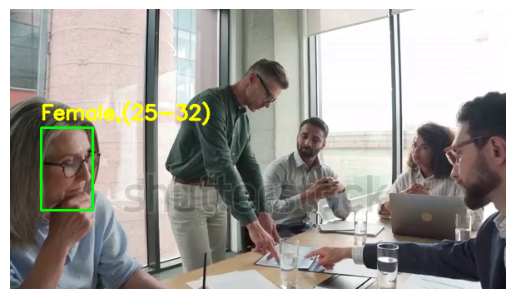

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
cap = cv2.VideoCapture('AgeandGender.mp4')
ret, frame = cap.read()
frame_height, frame_width, _ = frame.shape
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = age_gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")
plt.imshow(output[:,:,::-1])
plt.axis('off')
plt.show()

In [5]:
import cv2

# Read the video file
cap = cv2.VideoCapture('output.avi')

# Set the window size
cv2.namedWindow('video', cv2.WINDOW_NORMAL)
cv2.resizeWindow('video', 640, 480)

# Loop through the frames of the video
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret:
        # Display the frame in the window
        cv2.imshow('video', frame)

        # Wait for 25 milliseconds and check if the "q" key is pressed
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

# Release the video capture and destroy the window
cap.release()
cv2.destroyAllWindows()

